In [2]:
import torch
import torchvision.models as models
import h5py 
from logger import Logger
from torchvision.transforms import transforms 
import torch.utils.data as data
import numpy as np 
import pdb
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn 
import torch.optim as optim 
from torch.autograd import Variable
import shutil
import os 
import random
import torch.nn.functional as F

/home/aashi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class FrameDataset(data.Dataset):
    
    def __init__(self, f, transform=None, test = False):
        self.f = f 
        self.transform = transform 
        self.test = test
        
    def __getitem__(self, index):
#         if (not self.test):
#             rgb = np.array(self.f["rgb"][index])
# #             label = np.array((self.f["labels"][index] - self.f["Mean"])/self.f["Variance"])
#             label = np.array((self.f["labels"][index] - self.f["Mean"]))
#         else:
        rgb = np.array(self.f["rgb"][index])
#         label = np.array((self.f["labels"][index] - self.f["Mean"])/self.f["Variance"])
        label = np.array((self.f["labels"][index] - self.f["Mean"])) ## same mean through train, test 
        
        t_rgb = torch.zeros(rgb.shape[0], 3, 224, 224)
        
        prob = random.uniform(0, 1)
#         prob2 = random.uniform(0, 1)

        if self.transform is not None:
            for i in range(rgb.shape[0]):
                if (prob > 0.5 and not self.test):
                    flip_transform = transforms.Compose([transforms.ToPILImage(), transforms.RandomHorizontalFlip(1.0)])
                    rgb[i,:,:,:] = flip_transform(rgb[i,:,:,:])
                t_rgb[i,:,:,:] = self.transform(rgb[i,:,:,:])

                
        return rgb, t_rgb, label
    
    def __len__(self):
        return len(self.f["rgb"])

In [3]:
def load_vgg_voc_weights(MODEL_PATH):
    checkpoint_dict = torch.load(MODEL_PATH)
    vgg_model.load_state_dict(checkpoint_dict)

vgg_model = models.vgg16(pretrained=True)
num_final_in = vgg_model.classifier[-1].in_features
NUM_CLASSES = 20 ## in VOC
vgg_model.classifier[-1] = nn.Linear(num_final_in, NUM_CLASSES)
model_path = '/home/aashi/the_conclusion/model_files/' + 'vgg_on_voc' + str(800)
load_vgg_voc_weights(model_path)
# Why do I need to load vgg voc weights here 

In [4]:
class VGGNet(nn.Module):
    
    def __init__(self):
        super(VGGNet, self).__init__()
        self.rgb_net = self.get_vgg_features()
        
        kernel_size = 3 
        padding = int((kernel_size - 1)/2)
        self.conv_layer = nn.Conv2d(512, 16, kernel_size, 1, padding, bias=True)
        #self.conv_bn = nn.BatchNorm2d(16)
        ## input_channels, output_channels, kernel_size, stride, padding, bias
        self.feature_size = 16*7*7*3
        self.final_layer = nn.Sequential(
        nn.ReLU(),
        nn.Linear(self.feature_size, 2048),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(2048, 1)
        #nn.Sigmoid()
        #nn.Softmax()  ## If loss function uses Softmax  
        )
        
    def forward(self, rgb): ## sequence of four images - last index is latest 
        four_imgs = []
        for i in range(rgb.shape[1]):
            img_features = self.rgb_net(rgb[:,i,:,:,:])
            channels_reduced = self.conv_layer(img_features)
            img_features = channels_reduced.view((-1, 16*7*7))
            four_imgs.append(img_features)
        concat_output = torch.cat(four_imgs, dim = 1)
        out = self.final_layer(concat_output)
        return out
#         return concat_output
        
    def get_vgg_features(self):

        modules = list(vgg_model.children())[:-1]
        vgg16 = nn.Sequential(*modules)
        
        ## Uncommented this to let it fine-tune on my model 
        # for p in vgg16.parameters():
        #     p.requires_grad = False 
        
        return vgg16.type(torch.Tensor)

0.70131505
0.62287974


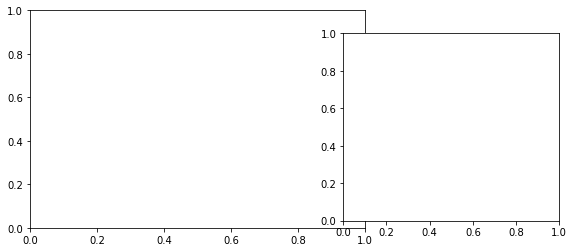

In [5]:
model = VGGNet().cuda()

def load_model_weights(MODEL_PATH):
    checkpoint_dict = torch.load(MODEL_PATH)
    model.load_state_dict(checkpoint_dict)
    
hfp_test = h5py.File('/mnt/hdd1/aashi/cmu_data/3ImageTest.h5', 'r')
mean = hfp_test["Mean"][()]
var = hfp_test["Variance"][()]
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
test_loader = data.DataLoader(FrameDataset(f = hfp_test, transform = transforms.Compose([transforms.ToTensor(), normalize]), test = True), 
                               batch_size=1)
#epoch_num = 4 ## Absolute mean error = 0.2584 (4 frames) vs 0.3022 (Single Image)
#epoch_num = 27 ## Absolute mean error = 0.753
# epoch_num = 10 ## 9 frames, Absolute error = 0.8169 

# epoch_num = 32 
# MODEL_PATH = '/mnt/hdd1/aashi/2Image6s_' + str(epoch_num).zfill(3)

epoch_num = 3
MODEL_PATH = '/mnt/hdd1/aashi/3Image6s_' + str(epoch_num).zfill(3)

# epoch_num = 4
# MODEL_PATH = '/mnt/hdd1/aashi/4Image6s_' + str(epoch_num).zfill(3)

# epoch_num = 27
# MODEL_PATH = '/mnt/hdd1/aashi/6Image6s_' + str(epoch_num).zfill(3)

load_model_weights(MODEL_PATH)

model.eval()
n = []
i = 0
prediction = []
groundTruth = []

ax1 = plt.axes()
ax2 = plt.axes([0.85, 0.15, 0.5, 0.65])

err = []
predictions = []

import timeit 
start = timeit.timeit()
for iter, (img, rgb, label) in enumerate(test_loader, 0):
    
    
    rgb = rgb.float().cuda()
    label = label.float().cuda()
    label = label.unsqueeze(-1)
    outputs = model(rgb)
#     end = timeit.timeit()
#     print(end - start)
#     pdb.set_trace()

    gt = label[0].data.cpu().numpy() + mean 
    pred = outputs[0].data.cpu().numpy() + mean 

#     if (pred[0] < 4.0):         ## see between 4-6 seconds, 3 is also close to mean  
#         continue

    
    predictions.append(pred)
    

#     pred = outputs[0].data.cpu().numpy() + mean 
#     gt = label[0].data.cpu().numpy() + mean 
#     pred = mean
    
    err.append(abs(pred[0] - gt[0]))
    
#     err.append(abs(pred - gt[0]))
    
#     pred = round(pred[0], 2)
#     gt = round(gt[0], 2)
    
#     n.append(i)
#     prediction.append(pred)
#     groundTruth.append(gt)
    
#     prediction = prediction[-30:]
#     groundTruth = groundTruth[-30:]
#     n = n[-30:]

#     ax1.imshow(img[0,-1,:,:,:]) ## current frame 
#     ax2.clear()
#     ax2.set_ylim(0, 8)

#     ax2.set_ylabel('time to proximity (in sec)', fontsize='medium')
#     ax2.set_xlabel('Current frame', fontsize='medium')
#     ax2.plot(n, prediction, 'b', label='Predicted time')
#     ax2.plot(n, groundTruth, 'r', label = 'Ground Truth')
#     ax2.legend(loc='upper center', shadow=True, fontsize='medium')    
    

#     plt.savefig('6ImageVideo/' + str(i) + '.png',bbox_inches='tight')
#     i = i+1
#     print(i)
    
print(np.mean(err))
print(np.std(err))

In [6]:
# predictions

In [7]:
# np.max(predictions)

In [8]:
# len(predictions)

In [9]:
# np.std(predictions)

In [3]:
hfp_test = h5py.File('/mnt/hdd1/aashi/cmu_data/6ImageTest.h5', 'r')
mean = hfp_test["Mean"][()]
var = hfp_test["Variance"][()]

In [4]:
mean

2.2997543581616484

In [5]:
var

2.9830609539231623